## Data Visualisation 

Course Data Visualiation by Prof. Konrad Föstner 

Finn Heydemann, Master, Digital Science TH Köln 

Winter Semester 2022/23 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import os 
import matplotlib.pyplot as plt
import datetime

In [3]:
col_names = pd.read_csv("archive/columns_description.csv")["columns_en"]

### Raw Data is not included in github repository as it is too large. 
As I only work with minimzed data (6 weather stations only) you will not need it.  <br>
If for some reasons you do need the raw data, please download them yourself from: <br>
https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

In [4]:
def read_single_w_station(filename: str):
    station_id = random_station(filename)
    rows_to_keep = set(np.where(pd.read_csv("archive/{}.csv".format(filename),
                                            usecols=["station_code"]) == station_id)[0] + 1)
    num_lines = sum(1 for _ in open("archive/{}.csv".format(filename)))
    rows_to_exclude = set(range(num_lines)) - rows_to_keep
    df = pd.read_csv("archive/{}.csv".format(filename),
                     skiprows=rows_to_exclude, header=None)
    df.drop(0, axis=1, inplace=True)
    df.columns = col_names
    df["timestamp"] = pd.to_datetime((df["date"] + "-" + df["hour"]), format="%Y-%m-%d-%H:%M")
    df.drop(["date", "hour"], axis=1, inplace=True)
    df.set_index("timestamp", inplace=True)
    df.sort_index(inplace=True)
    df.replace(-9999, np.nan, inplace=True)
    return df


def random_station(filename: str):
    np.random.seed(5)
    ids = np.unique(pd.read_csv("archive/{}.csv".format(filename),
                                usecols=["station_code"]))
    return np.random.choice(ids)

In [6]:
import os

def save_df(path, filename, df):
    if not os.path.exists(path): 
        os.mkdir(path)
    path = os.path.join(path, filename + ".csv")
    df.to_csv(path)

# only needed when working with raw data, else use functions below 
# takes a while as data is huge 
# activate by setting False to True
if False: 
    data = {x: read_single_w_station(x) for x in ["central_west", "south", "north", "northeast", "southeast"]} 
    for key in data.keys(): 
        save_df("read_data", key, data[key])

In [7]:
def read_data(path, filename): 
    path = os.path.join(path, filename + ".csv")
    df = pd.read_csv(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

data = {x: read_data("read_data", x) for x in ["central_west", "south", "north", "northeast", "southeast"]}

In [8]:
data["central_west"]

,total precipitation (mm),atmospheric pressure at station height (mb),atmospheric pressure max. in the previous hour (mb),atmospheric pressure min. in the previous hour (mb),radiation (kj/m2),air temperature - dry bulb (°c),dew point temperature (°c),max. temperature in the previous hour (°c),min. temperature in the previous hour (°c),dew temperature max. in the previous hour (°c),...,wind direction (° (gr)),wind rajada maxima (m/s),wind speed (m/s),region,state,station,station_code,latitude,longitude,height
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CO,MS,ARAL MOREIRA,S702,-22.955000,-55.626111,605.0
2018-04-13 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CO,MS,ARAL MOREIRA,S702,-22.955000,-55.626111,605.0
2018-04-13 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CO,MS,ARAL MOREIRA,S702,-22.955000,-55.626111,605.0
2018-04-13 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CO,MS,ARAL MOREIRA,S702,-22.955000,-55.626111,605.0
2018-04-13 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CO,MS,ARAL MOREIRA,S702,-22.955000,-55.626111,605.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00,0.0,947.0,947.5,947.0,1867.0,24.5,12.8,25.0,23.9,14.0,...,72.0,6.5,2.4,CO,MS,ARAL MOREIRA,S702,-22.955028,-55.626000,605.0
2021-04-30 20:00:00,0.0,947.2,947.2,947.0,1156.0,23.6,12.9,24.5,23.5,13.5,...,91.0,5.4,2.3,CO,MS,ARAL MOREIRA,S702,-22.955028,-55.626000,605.0
2021-04-30 21:00:00,0.0,947.4,947.4,947.2,382.0,20.9,12.6,23.6,20.9,13.3,...,76.0,4.3,2.1,CO,MS,ARAL MOREIRA,S702,-22.955028,-55.626000,605.0


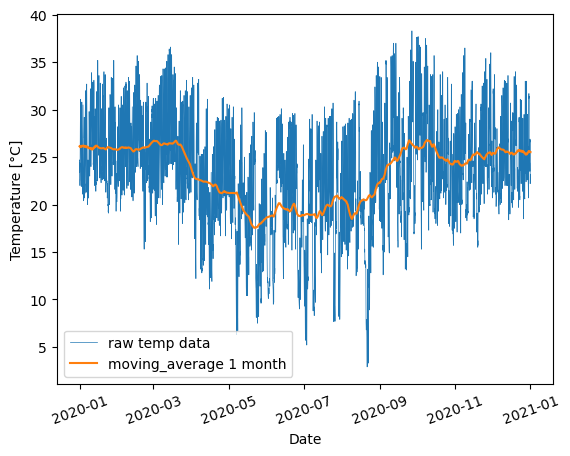

In [9]:
from scipy.ndimage import uniform_filter1d

def plot_temp(data, start_date, end_date, **kwargs): 
    fig, ax = plt.subplots()
    plot_data = data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                      "max. temperature in the previous hour (°c)"] 
    plot_data.fillna(method="ffill", inplace=True)
    plt.plot(plot_data, lw=0.5, label="raw temp data")
    if kwargs.get("moving_mean"):
        filter_period, period_type = kwargs.get("mov_mean_period")
        if period_type == "month": 
            filter_period *= 30 * 24 
        elif period_type == "day": 
            filter_period *= 24
        plt.plot(plot_data.index, uniform_filter1d(plot_data.to_numpy(), 
                                                   filter_period), 
                 label="moving_average {0} {1}".format(*kwargs.get("mov_mean_period")))
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    plt.xticks(rotation=20)
    plt.legend()


plot_temp(data["central_west"], (2020, 1, 1), (2021, 1, 1), moving_mean=True, mov_mean_period=(1, "month"))

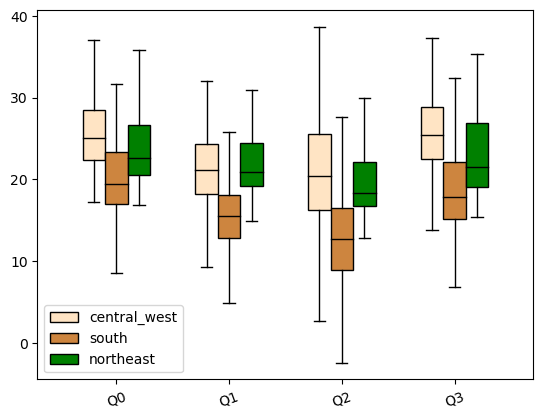

In [10]:
from itertools import cycle 

color = cycle(["bisque", "peru", "green", "lightblue", "plum"])

def boxplots(data, keys, start_date, end_date, seperator="Q"):
    """
    Makes a boxplot out of given data, start and end date can be defined as can be seperator which specifies 
    how data is seperated 
    
    # todo: If data is not present in one weather station, make sure plots are still on right quartil, month etc. 
    """
    w_stations = {}
    for key in keys: 
        plot_data = data[key]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                          "max. temperature in the previous hour (°c)"] 
        plot_data = plot_data.groupby(pd.Grouper(freq=seperator))
        d_single = {}
        for period in plot_data.groups.keys(): 
            x = plot_data.get_group(period).to_numpy()
            x[np.argwhere(np.isnan(x))] = np.nanmedian(x)
            d_single[period] = x
            
        w_stations[key] = d_single
    fig, ax = plt.subplots()
    elements = []
    for k, key in zip(np.linspace(-0.2, 0.2, len(keys)), keys):
        elements.append(ax.boxplot(w_stations[key].values(), 0, "", 
                                   positions=[k + l for l in range(len(w_stations[key]))],
                                   widths=0.2, 
                                   patch_artist=True, 
                                   boxprops={"facecolor":next(color)}, 
                                   medianprops={"color": "black"}
                                  ))
        
        plt.xticks(range(len(w_stations[key])), [seperator + str(j) for j in range(len(w_stations[key]))], 
                   rotation=20) 
    ax.legend([element["boxes"][0] for element in elements], [key for key in keys])

    
    
    
boxplots(data, ["central_west", "south", "northeast"], (2019, 1, 1), (2019, 12, 31), "Q")

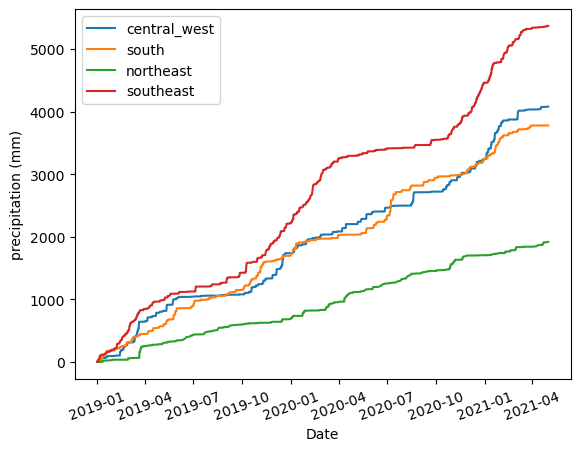

In [11]:
def cumulative_percipitation_plot(data, keys, start_date, end_date):
    fig, ax = plt.subplots()
    for key in keys: 
        plot_data = data[key]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                              ["total precipitation (mm)"]]
        plot_data.fillna(plot_data["total precipitation (mm)"].median(), inplace=True)
        plot_data["cumulative"] = np.cumsum(plot_data["total precipitation (mm)"])
        ax.plot(plot_data.index, plot_data["cumulative"].to_numpy(), label=key)
    ax.set_xlabel("Date")
    ax.set_ylabel("precipitation (mm)")
    plt.xticks(rotation=20)
    plt.legend()
    
    

cumulative_percipitation_plot(data, ["central_west", "south", "northeast", "southeast"], 
                              (2019, 1, 1), (2021, 12, 31))
    
    

In [12]:
import geopandas as gpd
shapefile = 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']

gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [42]:
df = data["central_west"]
df["latitude"].to_numpy()[0]

-22.955

In [45]:
df = {"name": [], "Latitude": [], "Longitude": []}
for key, value in data.items(): 
    df["name"].append(key)
    df["Latitude"].append(value.latitude.to_numpy()[0])
    df["Longitude"].append(value.longitude.to_numpy()[0])
    
df = pd.DataFrame(df)

<AxesSubplot: >

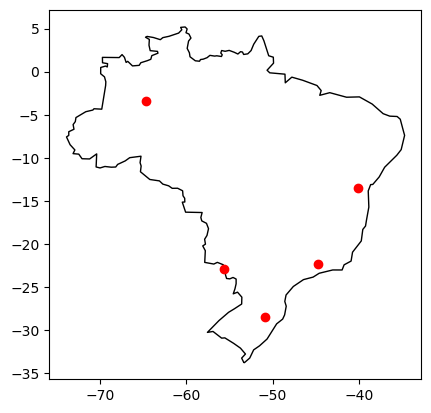

In [50]:
gxdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

ax = gdf[gdf["country"]=="Brazil"].plot(color="white", edgecolor="black")
gxdf.plot(ax=ax, color="red")